In [1]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
from yaml import dump, load, safe_load

In [21]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [2]:
log_path = "logs/"
log_file = "ts_decomposition.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [3]:
sys.path.append("../../sql")
import queries

In [4]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_locations"]["db_path"]
city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"
db_table1 = configs["file_locations"]["db_table1"]
db_table2 = configs["file_locations"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [7]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

# get_nsr_rows = queries.select_nsr_rows
# year1 = "2020"
# year2 = "2015"
# zipcode = "74145"

In [8]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['73108', '73109', '73110', '73115', '73119', '73129', '73130', '73135', '73139', '73145', '73149', '73150', '73159', '73160', '73165']


In [25]:
select_nsr_rows = f"""
SELECT date_time, year, zipcode,
Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature, Relative_Humidity from nsrdb
where zipcode = "73145"
and year in (2020, 2019, 2018, 2002, 2001, 2000);
"""

df = pd.read_sql(
    # get_nsr_rows,
    select_nsr_rows,
    conn,
    # params={"zipcode": zipcode, "year1": year1, "year2": year2},
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
df

,year,zipcode,DHI,DNI,GHI,Temperature,Relative_Humidity
date_time,,,,,,,
2000-01-01 00:30:00,2000,73145,0.0,0.0,0.0,4.0,89.33
2000-01-01 01:30:00,2000,73145,0.0,0.0,0.0,4.0,88.21
2000-01-01 02:30:00,2000,73145,0.0,0.0,0.0,3.0,93.64
2000-01-01 03:30:00,2000,73145,0.0,0.0,0.0,3.0,93.20
2000-01-01 04:30:00,2000,73145,0.0,0.0,0.0,3.0,93.63
...,...,...,...,...,...,...,...
2020-12-31 19:30:00,2020,73145,0.0,0.0,0.0,1.4,68.48
2020-12-31 20:30:00,2020,73145,0.0,0.0,0.0,1.1,68.09
2020-12-31 21:30:00,2020,73145,0.0,0.0,0.0,0.9,67.77


In [78]:
select_nsr_rows = f"""
SELECT date_time, year, zipcode,
Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature, Relative_Humidity,
Wind_Speed, Precipitable_Water
from nsrdb
where zipcode = "73145";
"""

df_ = pd.read_sql(
    # get_nsr_rows,
    select_nsr_rows,
    conn,
    # params={"zipcode": zipcode, "year1": year1, "year2": year2},
    index_col="date_time",
    parse_dates=["date_time"],
)

df_.sort_index(axis=0, inplace=True)
df_.head(5)

,year,zipcode,Clearsky_DHI,DHI,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Wind_Speed,Precipitable_Water
date_time,,,,,,,,,,,,
1998-01-01 00:30:00,1998,73145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.00,4.8,0.791
1998-01-01 00:30:00,1998,73145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.72,4.8,0.791
1998-01-01 00:30:00,1998,73145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.00,4.8,0.791
1998-01-01 00:30:00,1998,73145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.00,4.8,0.791
1998-01-01 01:30:00,1998,73145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.56,4.8,0.806


In [15]:
a_year_1 = 2018
a_year_2 = 2020
df_a = df[(df['year']>=a_year_1) & (df['year']<=a_year_2)].resample("M").mean().reset_index(drop=False)
df_a.set_index("date_time", inplace=True)

b_year_1 = 2000
b_year_2 = 2002
df_b = df[(df['year']>=b_year_1) & (df['year']<=b_year_2)].resample("M").mean().reset_index(drop=False)
df_b.set_index("date_time", inplace=True)

In [37]:
period=12
feature = "Temperature" # "Relative_Humidity" # "GHI"
decomp_a = seasonal_decompose(df_a[feature], model="additive", period=period)
decomp_b = seasonal_decompose(df_b[feature], model="additive", period=period)

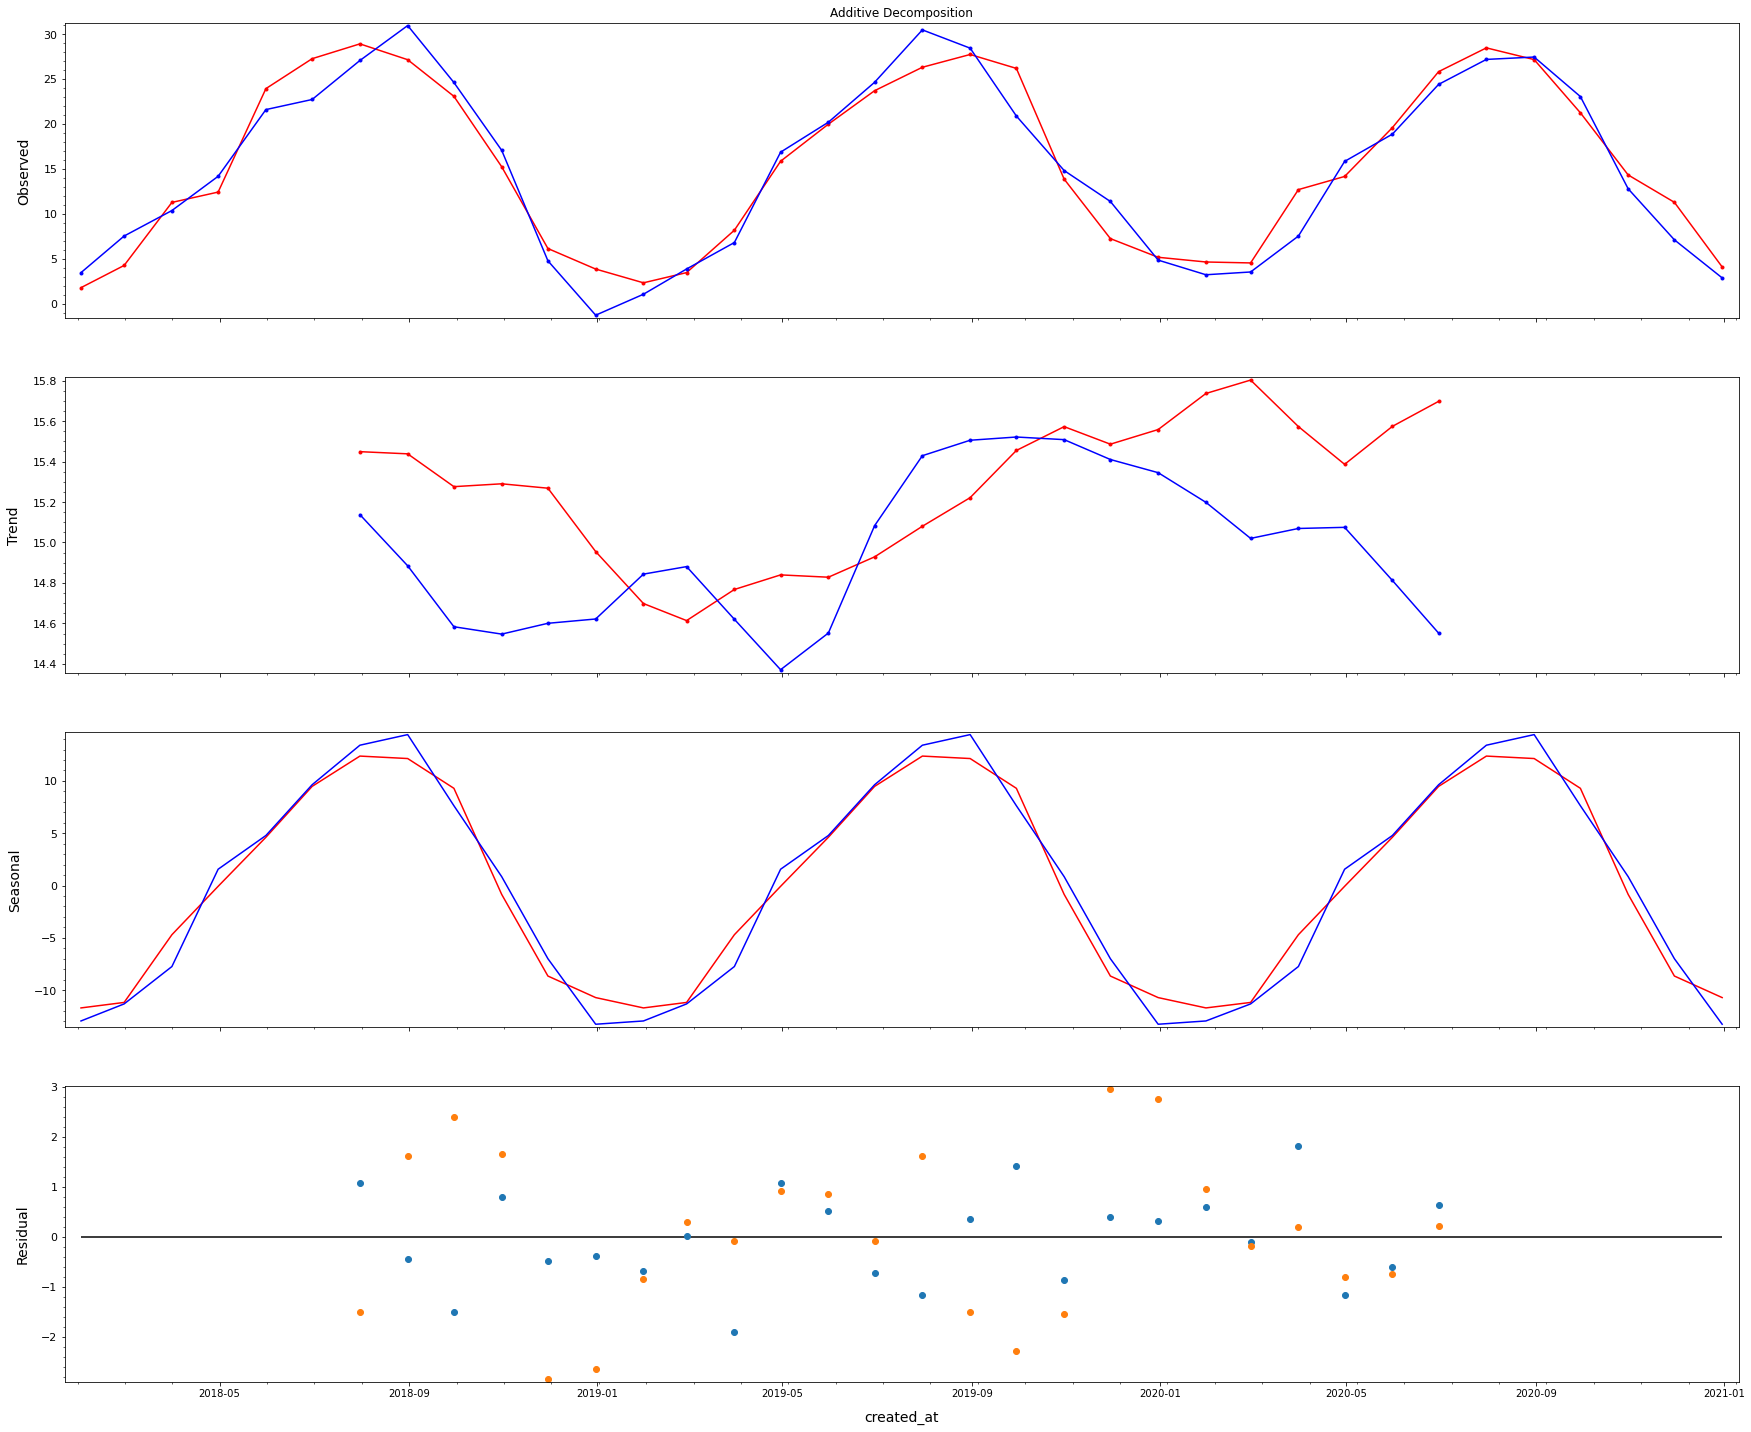

In [38]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, '.-', color='red')
ax[0].plot(decomp_a.observed.index, decomp_b.observed, '.-', color='blue')
ax[0].minorticks_on()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_a.trend.index, decomp_a.trend, '.-', color='red')
ax[1].plot(decomp_a.trend.index, decomp_b.trend, '.-', color='blue')
ax[1].minorticks_on()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_a.seasonal.index, decomp_a.seasonal, color='red')
ax[2].plot(decomp_a.seasonal.index, decomp_b.seasonal, color='blue')
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")

ax[3].plot(decomp_a.resid.index, decomp_a.resid, "o")
ax[3].plot(decomp_a.resid.index, decomp_b.resid, "o")
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [83]:
df_ = df_.resample("M").mean().reset_index(drop=False)
df_.set_index("date_time", inplace=True)

In [58]:
df_.head(1)

,year,Clearsky_DHI,DHI,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity
date_time,,,,,,,,,
2000-01-31,2000.0,30.912634,37.301075,290.27957,204.653226,150.657258,122.450269,3.436828,71.356895


In [66]:
period=12

feature_a = "Clearsky_DHI" # "Relative_Humidity"  # "Temperature"  # "GHI"
decomp_a= seasonal_decompose(df_[feature_a], model="additive", period=period)

feature_b = "DHI" # "Temperature"  # "Relative_Humidity" # "GHI"
decomp_b = seasonal_decompose(df_[feature_b], model="additive", period=period)

feature_c = "Clearsky_GHI" # "Relative_Humidity"  # "Temperature"  # "GHI"
decomp_c = seasonal_decompose(df_[feature_c], model="additive", period=period)

feature_d = "GHI" # "Temperature"  # "Relative_Humidity" # "GHI"
decomp_d = seasonal_decompose(df_[feature_d], model="additive", period=period)

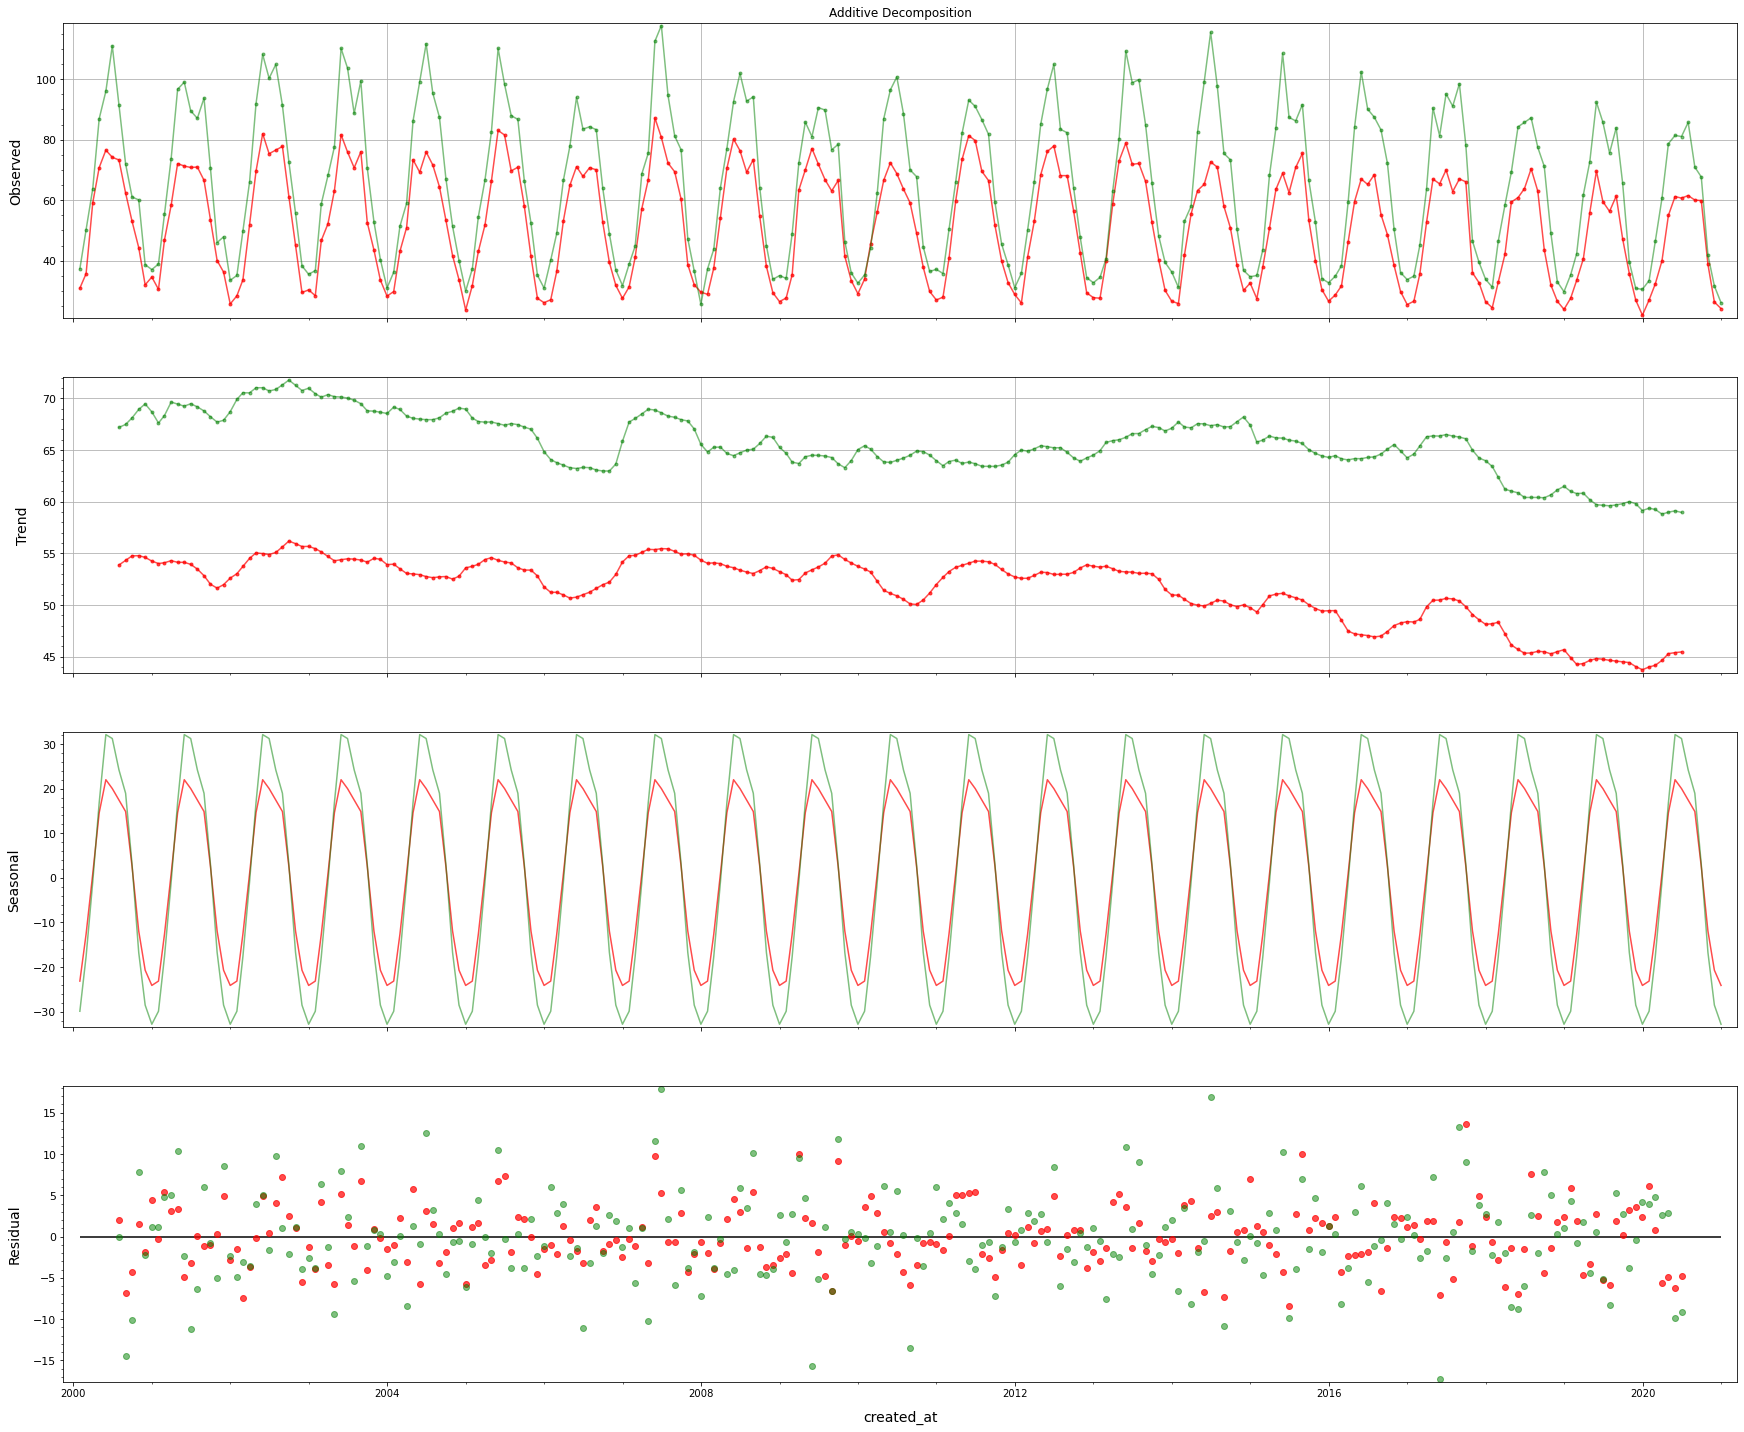

In [74]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

ax[0].plot(decomp_a.observed.index, decomp_a.observed, '.-', color='red', alpha=.7)
ax[0].plot(decomp_b.observed.index, decomp_b.observed, '.-', color='green', alpha=.5)
# ax[0].plot(decomp_c.observed.index, decomp_c.observed, 'o-', color='orange', alpha=.9)
# ax[0].plot(decomp_d.observed.index, decomp_d.observed, 'o-', color='blue', alpha=.6)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

ax[1].plot(decomp_a.trend.index, decomp_a.trend, '.-', color='red', alpha=.7)
ax[1].plot(decomp_b.trend.index, decomp_b.trend, '.-', color='green', alpha=.5)
# ax[1].plot(decomp_c.trend.index, decomp_c.trend, '.-', color='orange', alpha=.9)
# ax[1].plot(decomp_d.trend.index, decomp_d.trend, '.-', color='blue', alpha=.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp_a.seasonal.index, decomp_a.seasonal, color='red', alpha=.7)
ax[2].plot(decomp_b.seasonal.index, decomp_b.seasonal, color='green', alpha=.5)
# ax[2].plot(decomp_c.seasonal.index, decomp_c.seasonal, color='orange', alpha=.7)
# ax[2].plot(decomp_d.seasonal.index, decomp_d.seasonal, color='blue', alpha=.5)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")


ax[3].plot(decomp_a.resid.index, decomp_a.resid, "o", color='red', alpha=.7)
ax[3].plot(decomp_b.resid.index, decomp_b.resid, "o", color='green', alpha=.5)
# ax[3].plot(decomp_c.resid.index, decomp_c.resid, "o", color='orange', alpha=.7)
# ax[3].plot(decomp_d.resid.index, decomp_d.resid, "o", color='blue', alpha=.5)
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()

In [84]:
period=12

feature_e = "Temperature"
decomp_e= seasonal_decompose(df_[feature_e], model="additive", period=period)

feature_f = "Relative_Humidity"
decomp_f = seasonal_decompose(df_[feature_f], model="additive", period=period)

feature_g = "Wind_Speed"
decomp_g = seasonal_decompose(df_[feature_g], model="additive", period=period)

feature_h = "Precipitable_Water"
decomp_h = seasonal_decompose(df_[feature_d], model="additive", period=period)

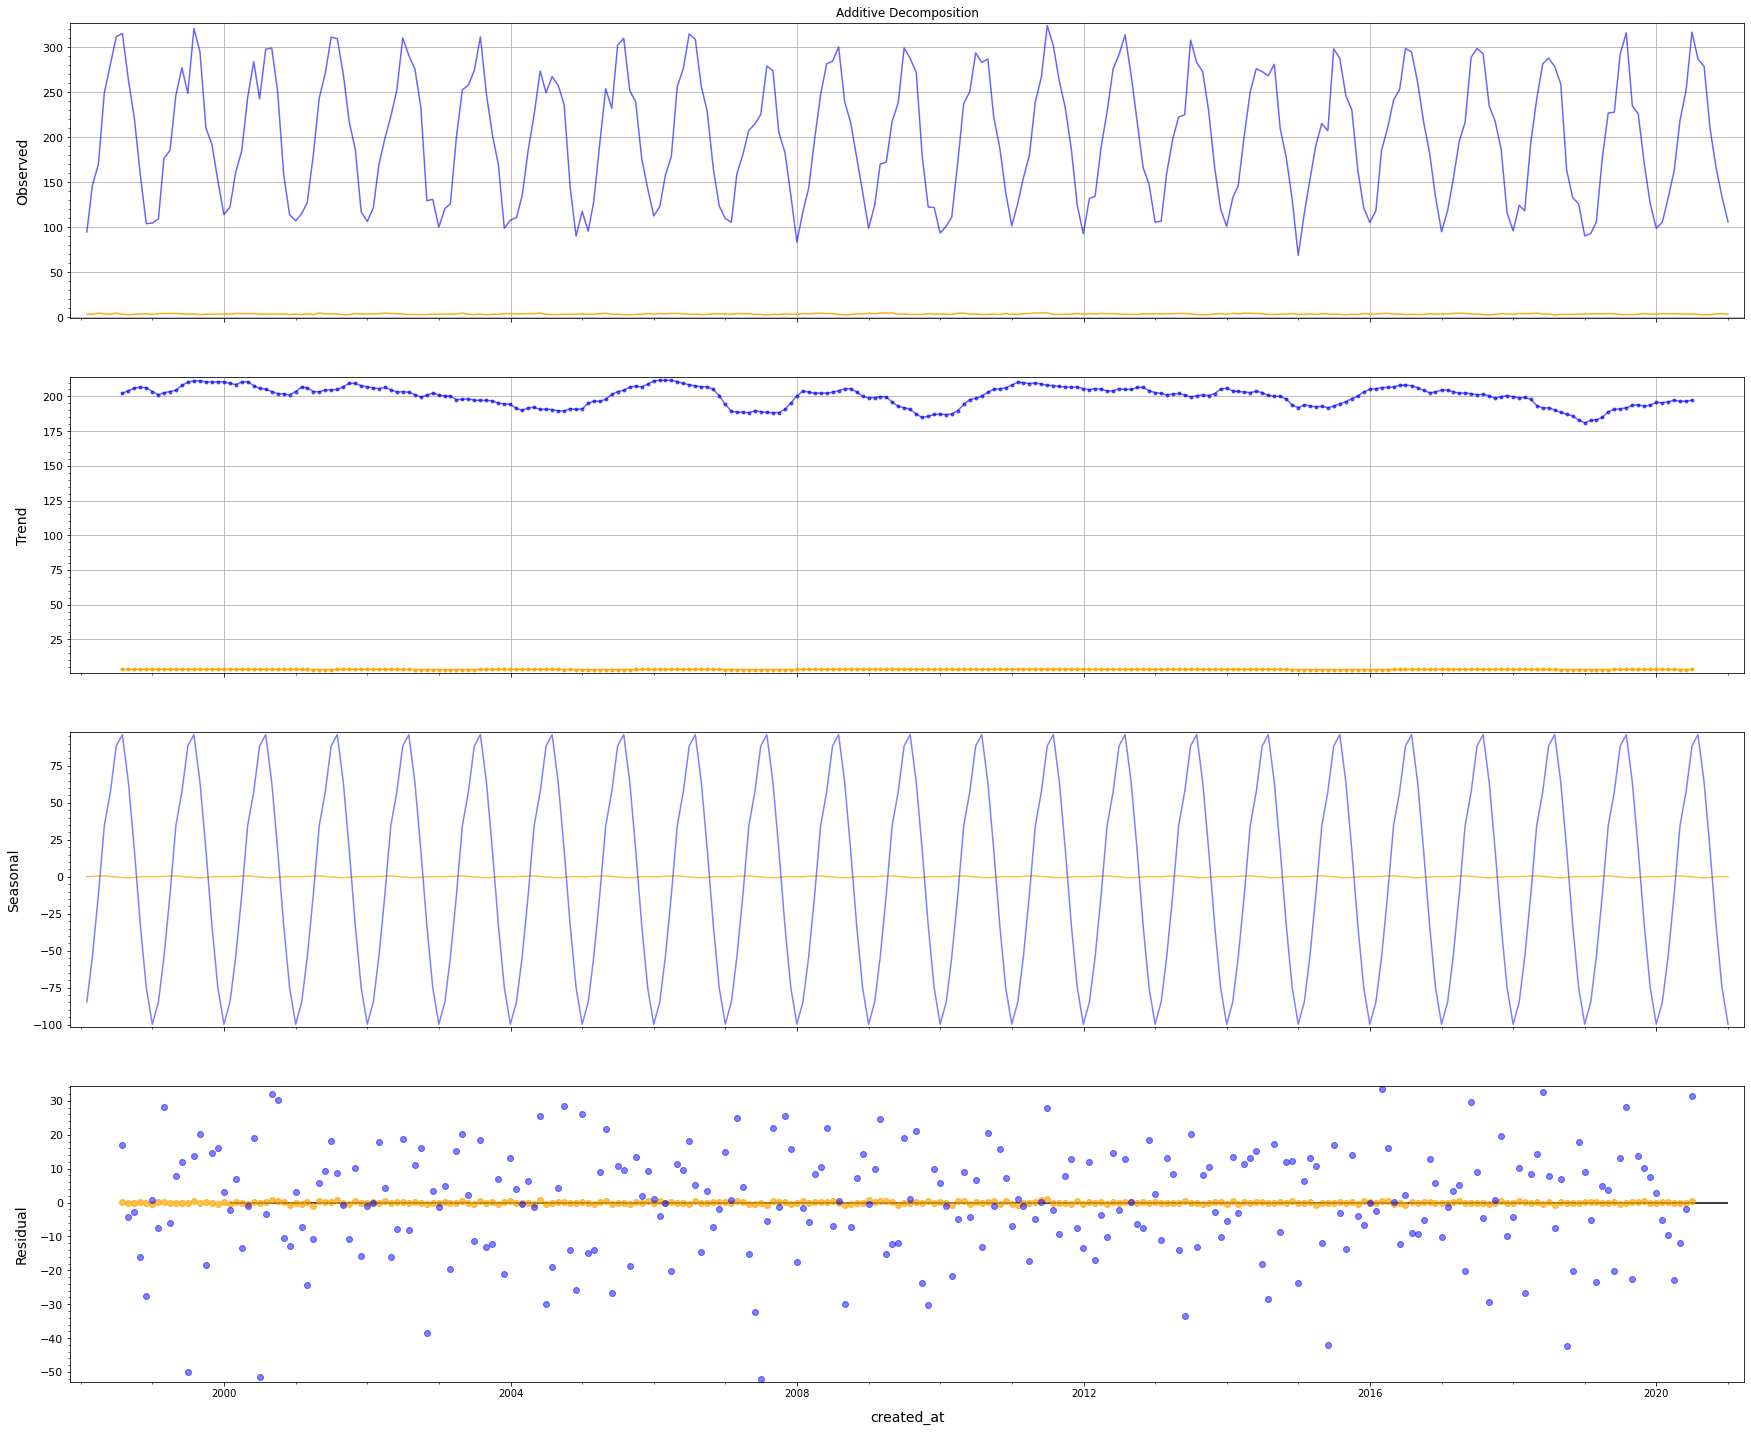

In [86]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")

# ax[0].plot(decomp_e.observed.index, decomp_e.observed, '-', color='red', alpha=.7)
# ax[0].plot(decomp_f.observed.index, decomp_f.observed, '-', color='green', alpha=.5)
ax[0].plot(decomp_g.observed.index, decomp_g.observed, '-', color='orange', alpha=.9)
ax[0].plot(decomp_h.observed.index, decomp_h.observed, '-', color='blue', alpha=.6)
ax[0].minorticks_on()
ax[0].grid()
ax[0].set(ylabel="Observed")

# ax[1].plot(decomp_e.trend.index, decomp_e.trend, '-', color='red', alpha=.7)
# ax[1].plot(decomp_f.trend.index, decomp_f.trend, '-', color='green', alpha=.5)
ax[1].plot(decomp_g.trend.index, decomp_g.trend, '.-', color='orange', alpha=.9)
ax[1].plot(decomp_h.trend.index, decomp_h.trend, '.-', color='blue', alpha=.6)
ax[1].minorticks_on()
ax[1].grid()
ax[1].set(ylabel="Trend")

# ax[2].plot(decomp_e.seasonal.index, decomp_e.seasonal, '-', color='red', alpha=.7)
# ax[2].plot(decomp_f.seasonal.index, decomp_f.seasonal, '-', color='green', alpha=.5)
ax[2].plot(decomp_g.seasonal.index, decomp_g.seasonal, '-', color='orange', alpha=.7)
ax[2].plot(decomp_h.seasonal.index, decomp_h.seasonal, '-', color='blue', alpha=.5)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")


# ax[3].plot(decomp_e.resid.index, decomp_e.resid, "o", color='red', alpha=.7)
# ax[3].plot(decomp_f.resid.index, decomp_f.resid, "o", color='green', alpha=.5)
ax[3].plot(decomp_g.resid.index, decomp_g.resid, "o", color='orange', alpha=.7)
ax[3].plot(decomp_h.resid.index, decomp_h.resid, "o", color='blue', alpha=.5)
ax[3].hlines(0, xmin=min(decomp_a.resid.index), xmax=max(decomp_a.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()